# DSA 2040 Practical Exam - Section 2, Task 1
## Data Preprocessing for Data Mining

**Student:** Monaheng218  
**Date:** August 13, 2025  
**Total Marks:** 15

### Task Requirements:
1. Load and explore the retail dataset from data warehouse
2. Handle missing values and outliers
3. Feature engineering and transformation
4. Data normalization and scaling
5. Prepare datasets for different mining tasks (clustering, classification, association rules)

In [1]:
# =============================================================================
# IMPORTS AND SETUP
# =============================================================================

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Data Mining libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn imported successfully")

✅ Data Mining libraries imported successfully
Pandas version: 2.0.3
NumPy version: 1.24.3
Scikit-learn imported successfully


In [2]:
# =============================================================================
# DATA LOADING AND EXPLORATION
# =============================================================================

print("\n" + "="*60)
print("STEP 1: DATA LOADING AND EXPLORATION")
print("="*60)

# Connect to the data warehouse
db_path = '../Section1_DataWarehousing/retail_dw.db'
conn = sqlite3.connect(db_path)

# Load comprehensive dataset for mining
mining_query = """
SELECT 
    s.SalesKey,
    s.InvoiceNo,
    s.CustomerKey,
    s.ProductKey,
    s.TimeKey,
    s.Quantity,
    s.UnitPrice,
    s.TotalSales,
    
    -- Customer information
    c.CustomerID,
    c.Country,
    
    -- Product information
    p.StockCode,
    p.Description as ProductDescription,
    p.Category,
    
    -- Time information
    t.Date,
    t.Year,
    t.Month,
    t.Day,
    t.Quarter,
    t.DayOfWeek,
    t.MonthName,
    t.DayName
    
FROM SalesFact s
JOIN CustomerDim c ON s.CustomerKey = c.CustomerKey
JOIN ProductDim p ON s.ProductKey = p.ProductKey
JOIN TimeDim t ON s.TimeKey = t.TimeKey;
"""

# Load the data
df_mining = pd.read_sql_query(mining_query, conn)
conn.close()

print(f"📊 Dataset loaded successfully")
print(f"Shape: {df_mining.shape}")
print(f"Memory usage: {df_mining.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Basic exploration
print("\n📋 Dataset Overview:")
print(df_mining.info())

print("\n📊 Statistical Summary:")
print(df_mining.describe())

print("\n🔍 First 5 rows:")
print(df_mining.head())

# Check for missing values
print("\n❌ Missing Values:")
missing_values = df_mining.isnull().sum()
missing_percent = (missing_values / len(df_mining)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

# Data types analysis
print("\n📊 Data Types:")
print(df_mining.dtypes.value_counts())


STEP 1: DATA LOADING AND EXPLORATION
📊 Dataset loaded successfully
Shape: (3101, 21)
Memory usage: 1.84 MB

📋 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3101 entries, 0 to 3100
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SalesKey            3101 non-null   int64  
 1   InvoiceNo           3101 non-null   object 
 2   CustomerKey         3101 non-null   int64  
 3   ProductKey          3101 non-null   int64  
 4   TimeKey             3101 non-null   int64  
 5   Quantity            3101 non-null   int64  
 6   UnitPrice           3101 non-null   float64
 7   TotalSales          3101 non-null   float64
 8   CustomerID          3101 non-null   int64  
 9   Country             3101 non-null   object 
 10  StockCode           3101 non-null   object 
 11  ProductDescription  3101 non-null   object 
 12  Category            3101 non-null   object 
 13  Date                3101


STEP 2: DATA QUALITY ASSESSMENT
🔄 Duplicate rows: 0

🔍 Outlier Analysis:
   Quantity: 69 outliers (2.2%)
   UnitPrice: 0 outliers (0.0%)
   TotalSales: 87 outliers (2.8%)


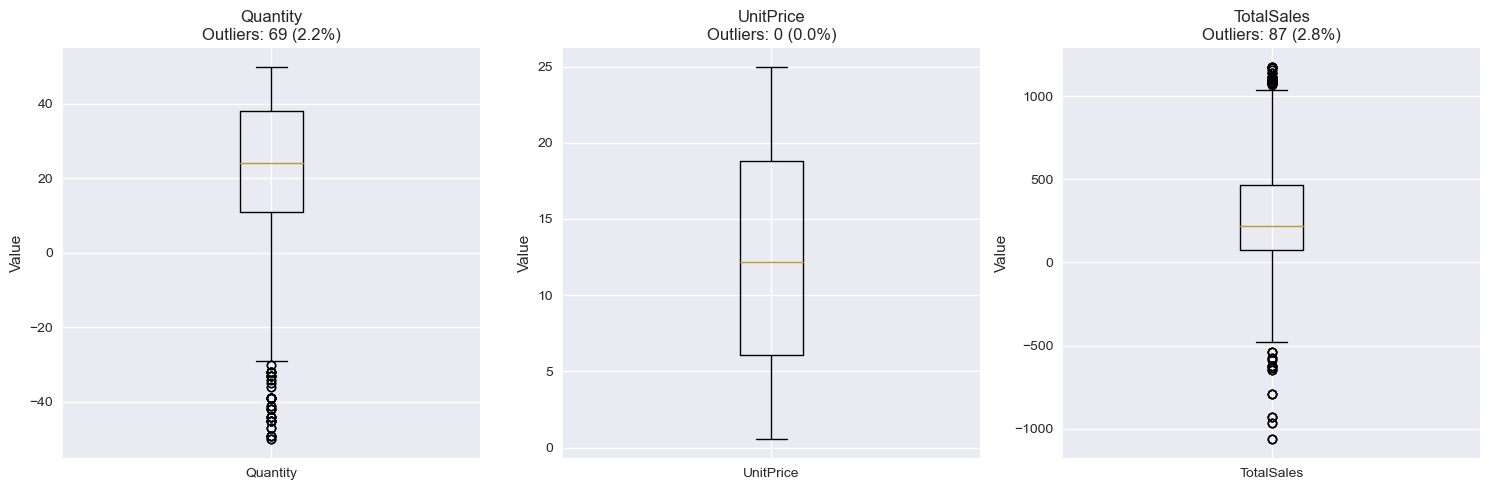


📊 Distribution Analysis:


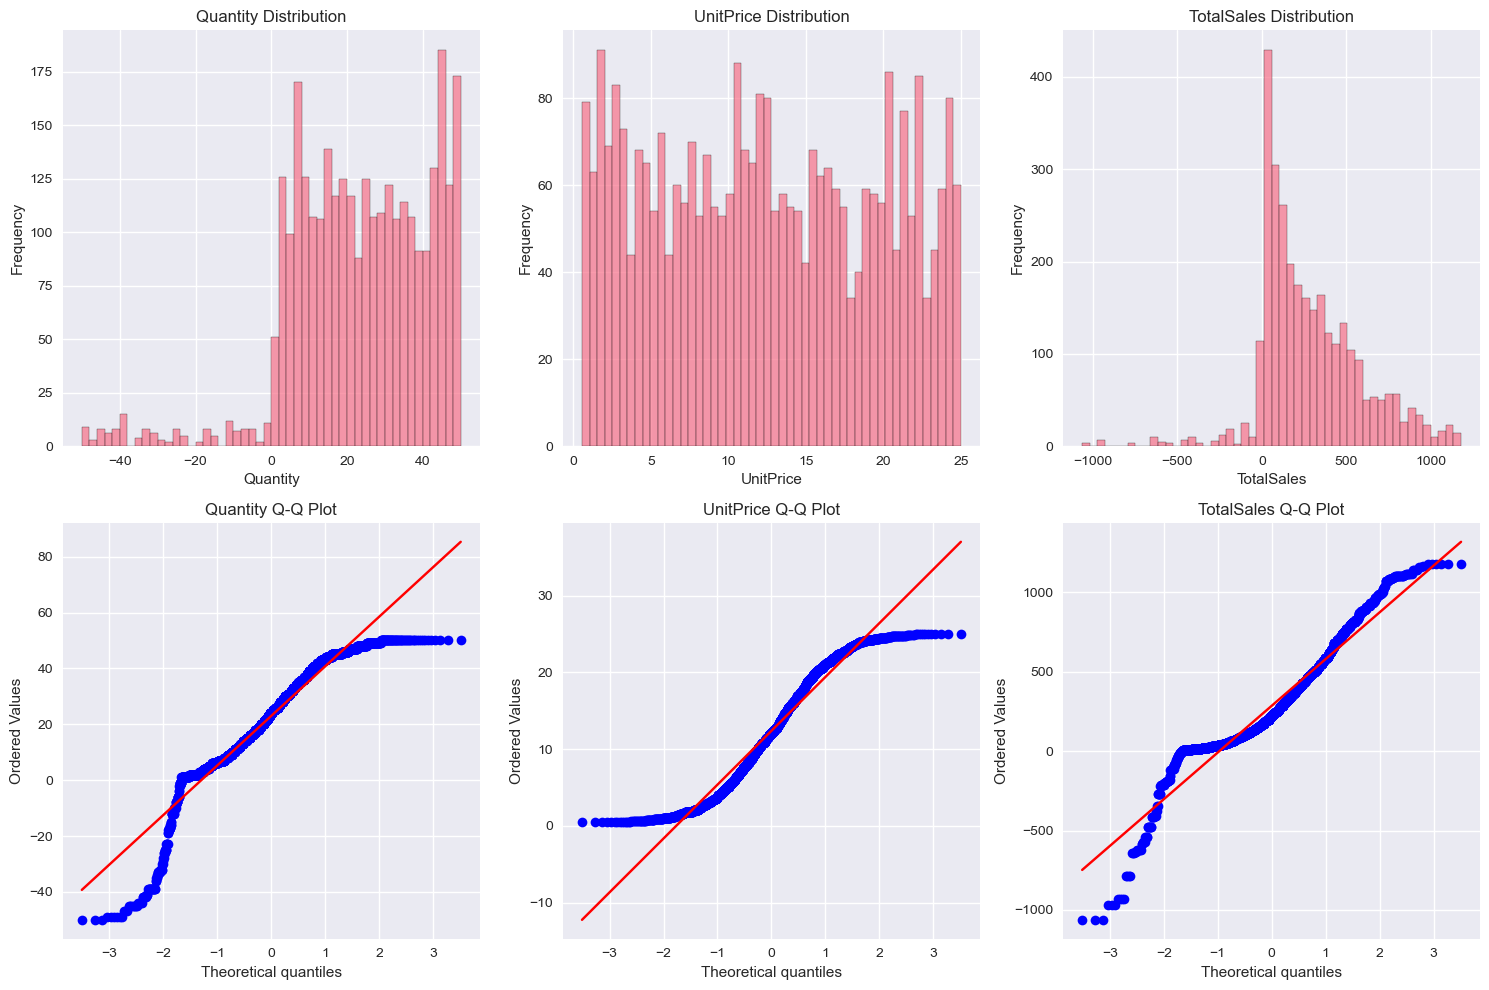


📊 Categorical Variables Analysis:
   Country: 16 unique values
      Top 5: {'Germany': 250, 'Netherlands': 245, 'Lithuania': 236, 'United Kingdom': 233, 'Italy': 231}

   Category: 7 unique values
      Values: ['TO', 'DE', 'GA', 'HO', 'KI', 'GI', 'OF']
      Top 5: {'GI': 486, 'HO': 485, 'DE': 465, 'TO': 437, 'OF': 427}

   Quarter: 4 unique values
      Values: [2, 1, 4, 3]
      Top 5: {2: 964, 3: 742, 1: 730, 4: 665}

   DayName: 7 unique values
      Values: ['Friday', 'Saturday', 'Tuesday', 'Sunday', 'Monday', 'Wednesday', 'Thursday']
      Top 5: {'Wednesday': 532, 'Tuesday': 514, 'Sunday': 465, 'Saturday': 452, 'Friday': 388}



In [3]:
# =============================================================================
# DATA QUALITY ASSESSMENT
# =============================================================================

print("\n" + "="*60)
print("STEP 2: DATA QUALITY ASSESSMENT")
print("="*60)

# Check for duplicates
duplicates = df_mining.duplicated().sum()
print(f"🔄 Duplicate rows: {duplicates}")

# Check for outliers in numerical columns
numerical_cols = ['Quantity', 'UnitPrice', 'TotalSales']

print("\n🔍 Outlier Analysis:")
plt.figure(figsize=(15, 5))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    
    # Calculate outliers using IQR method
    Q1 = df_mining[col].quantile(0.25)
    Q3 = df_mining[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_mining[(df_mining[col] < lower_bound) | (df_mining[col] > upper_bound)]
    
    # Box plot
    plt.boxplot(df_mining[col], labels=[col])
    plt.title(f'{col}\nOutliers: {len(outliers)} ({len(outliers)/len(df_mining)*100:.1f}%)')
    plt.ylabel('Value')
    
    print(f"   {col}: {len(outliers)} outliers ({len(outliers)/len(df_mining)*100:.1f}%)")

plt.tight_layout()
plt.show()

# Distribution analysis
print("\n📊 Distribution Analysis:")
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols, 1):
    # Histogram
    plt.subplot(2, 3, i)
    plt.hist(df_mining[col], bins=50, alpha=0.7, edgecolor='black')
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    # Q-Q plot
    plt.subplot(2, 3, i+3)
    stats.probplot(df_mining[col], dist="norm", plot=plt)
    plt.title(f'{col} Q-Q Plot')

plt.tight_layout()
plt.show()

# Categorical variables analysis
categorical_cols = ['Country', 'Category', 'Quarter', 'DayName']
print("\n📊 Categorical Variables Analysis:")

for col in categorical_cols:
    unique_count = df_mining[col].nunique()
    print(f"   {col}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"      Values: {df_mining[col].unique().tolist()}")
    print(f"      Top 5: {df_mining[col].value_counts().head().to_dict()}")
    print()

In [4]:
# =============================================================================
# DATA CLEANING AND PREPROCESSING
# =============================================================================

print("\n" + "="*60)
print("STEP 3: DATA CLEANING AND PREPROCESSING")
print("="*60)

# Create a copy for processing
df_clean = df_mining.copy()
print(f"Starting with {len(df_clean)} records")

# 1. Remove duplicates
df_clean = df_clean.drop_duplicates()
print(f"After removing duplicates: {len(df_clean)} records")

# 2. Handle missing values (if any)
# Fill missing product descriptions
if df_clean['ProductDescription'].isnull().any():
    df_clean['ProductDescription'] = df_clean['ProductDescription'].fillna('Unknown Product')
    print("✅ Filled missing product descriptions")

# 3. Remove extreme outliers (beyond 3 standard deviations)
print("\n🔧 Outlier Treatment:")
for col in numerical_cols:
    mean = df_clean[col].mean()
    std = df_clean[col].std()
    
    # Define outliers as values beyond 3 standard deviations
    outlier_mask = np.abs(df_clean[col] - mean) > 3 * std
    outliers_removed = outlier_mask.sum()
    
    if outliers_removed > 0:
        df_clean = df_clean[~outlier_mask]
        print(f"   {col}: Removed {outliers_removed} extreme outliers")

print(f"After outlier removal: {len(df_clean)} records")

# 4. Feature Engineering
print("\n🔧 Feature Engineering:")

# Create derived features
df_clean['PriceCategory'] = pd.cut(df_clean['UnitPrice'], 
                                  bins=[0, 5, 15, 50, np.inf], 
                                  labels=['Low', 'Medium', 'High', 'Premium'])

df_clean['QuantityCategory'] = pd.cut(df_clean['Quantity'], 
                                     bins=[0, 5, 20, 50, np.inf], 
                                     labels=['Small', 'Medium', 'Large', 'Bulk'])

df_clean['SalesCategory'] = pd.cut(df_clean['TotalSales'], 
                                  bins=[0, 50, 200, 500, np.inf], 
                                  labels=['Low', 'Medium', 'High', 'Premium'])

# Create time-based features
df_clean['IsWeekend'] = df_clean['DayOfWeek'].isin([6, 7]).astype(int)
df_clean['Season'] = df_clean['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})

# Calculate customer metrics
customer_metrics = df_clean.groupby('CustomerKey').agg({
    'TotalSales': ['sum', 'mean', 'count'],
    'Quantity': 'sum',
    'InvoiceNo': 'nunique'
}).round(2)

customer_metrics.columns = ['TotalSpent', 'AvgTransactionValue', 'TransactionCount', 
                           'TotalQuantity', 'UniqueInvoices']
customer_metrics = customer_metrics.reset_index()

# Merge customer metrics back
df_clean = df_clean.merge(customer_metrics, on='CustomerKey', how='left')

# Calculate product metrics
product_metrics = df_clean.groupby('ProductKey').agg({
    'TotalSales': 'sum',
    'Quantity': 'sum',
    'CustomerKey': 'nunique'
}).round(2)

product_metrics.columns = ['ProductTotalSales', 'ProductTotalQuantity', 'ProductCustomerCount']
product_metrics = product_metrics.reset_index()

# Merge product metrics back
df_clean = df_clean.merge(product_metrics, on='ProductKey', how='left')

print(f"✅ Created derived features:")
print(f"   • Price/Quantity/Sales categories")
print(f"   • Time-based features (Weekend, Season)")
print(f"   • Customer metrics (Total spent, avg transaction, etc.)")
print(f"   • Product metrics (Total sales, popularity)")

print(f"\n📊 Final cleaned dataset shape: {df_clean.shape}")


STEP 3: DATA CLEANING AND PREPROCESSING
Starting with 3101 records
After removing duplicates: 3101 records

🔧 Outlier Treatment:
   Quantity: Removed 61 extreme outliers
   TotalSales: Removed 11 extreme outliers
After outlier removal: 3029 records

🔧 Feature Engineering:
✅ Created derived features:
   • Price/Quantity/Sales categories
   • Time-based features (Weekend, Season)
   • Customer metrics (Total spent, avg transaction, etc.)
   • Product metrics (Total sales, popularity)

📊 Final cleaned dataset shape: (3029, 34)


In [5]:
# =============================================================================
# DATA TRANSFORMATION AND NORMALIZATION
# =============================================================================

print("\n" + "="*60)
print("STEP 4: DATA TRANSFORMATION AND NORMALIZATION")
print("="*60)

# Prepare different datasets for different mining tasks

# 1. CLUSTERING DATASET - Customer Segmentation
print("\n🎯 Preparing Clustering Dataset (Customer Segmentation):")

clustering_features = [
    'TotalSpent', 'AvgTransactionValue', 'TransactionCount', 
    'TotalQuantity', 'UniqueInvoices'
]

df_clustering = customer_metrics.copy()

# Add customer behavioral features
customer_behavior = df_clean.groupby('CustomerKey').agg({
    'Category': lambda x: x.nunique(),  # Product diversity
    'Country': 'first',
    'Month': lambda x: x.nunique(),     # Shopping frequency across months
    'IsWeekend': 'mean',                # Weekend shopping preference
    'UnitPrice': 'mean'                 # Average price preference
}).round(3)

customer_behavior.columns = ['ProductDiversity', 'Country', 'MonthSpread', 
                            'WeekendPreference', 'AvgPricePreference']
customer_behavior = customer_behavior.reset_index()

df_clustering = df_clustering.merge(customer_behavior, on='CustomerKey')

# Encode categorical variables
le_country = LabelEncoder()
df_clustering['Country_encoded'] = le_country.fit_transform(df_clustering['Country'])

# Select numerical features for clustering
clustering_numerical = [
    'TotalSpent', 'AvgTransactionValue', 'TransactionCount', 
    'TotalQuantity', 'ProductDiversity', 'MonthSpread', 
    'WeekendPreference', 'AvgPricePreference', 'Country_encoded'
]

X_clustering = df_clustering[clustering_numerical].copy()

# Normalize features for clustering
scaler_clustering = StandardScaler()
X_clustering_scaled = scaler_clustering.fit_transform(X_clustering)
X_clustering_scaled = pd.DataFrame(X_clustering_scaled, columns=clustering_numerical)

print(f"   ✅ Clustering dataset: {X_clustering_scaled.shape}")
print(f"   📊 Features: {clustering_numerical}")

# 2. CLASSIFICATION DATASET - Customer Value Prediction
print("\n🎯 Preparing Classification Dataset (Customer Value Prediction):")

# Create target variable - Customer Value Category
customer_value_percentiles = df_clustering['TotalSpent'].quantile([0.33, 0.66])
df_clustering['CustomerValueCategory'] = pd.cut(
    df_clustering['TotalSpent'], 
    bins=[-np.inf, customer_value_percentiles.iloc[0], customer_value_percentiles.iloc[1], np.inf],
    labels=['Low', 'Medium', 'High']
)

# Features for classification
classification_features = [
    'AvgTransactionValue', 'TransactionCount', 'ProductDiversity', 
    'MonthSpread', 'WeekendPreference', 'AvgPricePreference', 'Country_encoded'
]

X_classification = df_clustering[classification_features].copy()
y_classification = df_clustering['CustomerValueCategory'].copy()

# Encode target variable
le_target = LabelEncoder()
y_classification_encoded = le_target.fit_transform(y_classification)

# Scale features for classification
scaler_classification = StandardScaler()
X_classification_scaled = scaler_classification.fit_transform(X_classification)
X_classification_scaled = pd.DataFrame(X_classification_scaled, columns=classification_features)

print(f"   ✅ Classification dataset: {X_classification_scaled.shape}")
print(f"   📊 Features: {classification_features}")
print(f"   🎯 Target distribution: {pd.Series(y_classification).value_counts().to_dict()}")

# 3. ASSOCIATION RULES DATASET - Market Basket Analysis
print("\n🎯 Preparing Association Rules Dataset (Market Basket Analysis):")

# Create transaction-product matrix
basket_data = df_clean.groupby(['InvoiceNo', 'ProductDescription'])['Quantity'].sum().unstack().fillna(0)

# Convert to binary (purchased or not)
basket_binary = (basket_data > 0).astype(int)

# Filter products that appear in at least 1% of transactions
min_support = 0.01
product_support = basket_binary.mean()
frequent_products = product_support[product_support >= min_support].index
basket_frequent = basket_binary[frequent_products]

print(f"   ✅ Association rules dataset: {basket_frequent.shape}")
print(f"   📊 Transactions: {len(basket_frequent)}")
print(f"   📦 Products (min support {min_support*100}%): {len(frequent_products)}")
print(f"   🔍 Top products by frequency:")
top_products = product_support[frequent_products].sort_values(ascending=False).head(10)
for product, support in top_products.items():
    print(f"      {product[:50]}: {support:.3f}")

print("\n✅ All datasets prepared successfully for data mining tasks!")


STEP 4: DATA TRANSFORMATION AND NORMALIZATION

🎯 Preparing Clustering Dataset (Customer Segmentation):
   ✅ Clustering dataset: (419, 9)
   📊 Features: ['TotalSpent', 'AvgTransactionValue', 'TransactionCount', 'TotalQuantity', 'ProductDiversity', 'MonthSpread', 'WeekendPreference', 'AvgPricePreference', 'Country_encoded']

🎯 Preparing Classification Dataset (Customer Value Prediction):
   ✅ Classification dataset: (419, 7)
   📊 Features: ['AvgTransactionValue', 'TransactionCount', 'ProductDiversity', 'MonthSpread', 'WeekendPreference', 'AvgPricePreference', 'Country_encoded']
   🎯 Target distribution: {'High': 143, 'Low': 138, 'Medium': 138}

🎯 Preparing Association Rules Dataset (Market Basket Analysis):
   ✅ Association rules dataset: (477, 1)
   📊 Transactions: 477
   📦 Products (min support 1.0%): 1
   🔍 Top products by frequency:
      Unknown Product: 0.040

✅ All datasets prepared successfully for data mining tasks!


In [6]:
# =============================================================================
# SAVE PREPROCESSED DATASETS
# =============================================================================

print("\n" + "="*60)
print("STEP 5: SAVING PREPROCESSED DATASETS")
print("="*60)

# Save datasets for different mining tasks
print("💾 Saving preprocessed datasets...")

# 1. Save clustering dataset
X_clustering_scaled.to_csv('clustering_dataset.csv', index=False)
df_clustering.to_csv('clustering_dataset_full.csv', index=False)
print("   ✅ Clustering dataset saved")

# 2. Save classification dataset
X_classification_scaled.to_csv('classification_features.csv', index=False)
pd.Series(y_classification_encoded, name='CustomerValueCategory').to_csv('classification_target.csv', index=False)
df_clustering[['CustomerKey'] + classification_features + ['CustomerValueCategory']].to_csv('classification_dataset_full.csv', index=False)
print("   ✅ Classification dataset saved")

# 3. Save association rules dataset
basket_frequent.to_csv('association_rules_dataset.csv', index=True)
print("   ✅ Association rules dataset saved")

# 4. Save the complete cleaned dataset
df_clean.to_csv('complete_cleaned_dataset.csv', index=False)
print("   ✅ Complete cleaned dataset saved")

# Save label encoders and scalers for future use
import pickle

with open('preprocessing_objects.pkl', 'wb') as f:
    pickle.dump({
        'scaler_clustering': scaler_clustering,
        'scaler_classification': scaler_classification,
        'le_country': le_country,
        'le_target': le_target,
        'clustering_features': clustering_numerical,
        'classification_features': classification_features
    }, f)
print("   ✅ Preprocessing objects saved")

# Summary statistics
print("\n📊 PREPROCESSING SUMMARY:")
print("=" * 40)
print(f"Original dataset: {df_mining.shape[0]:,} records, {df_mining.shape[1]} features")
print(f"Cleaned dataset: {df_clean.shape[0]:,} records, {df_clean.shape[1]} features")
print(f"Data retention rate: {(len(df_clean)/len(df_mining))*100:.1f}%")
print()
print("📁 Files created:")
print("   • clustering_dataset.csv - Customer segmentation features")
print("   • classification_dataset_full.csv - Customer value prediction")
print("   • association_rules_dataset.csv - Market basket analysis")
print("   • complete_cleaned_dataset.csv - Full cleaned dataset")
print("   • preprocessing_objects.pkl - Scalers and encoders")
print()
print("🎯 Ready for data mining tasks:")
print("   1. ✅ Clustering (Customer Segmentation)")
print("   2. ✅ Classification (Customer Value Prediction)")
print("   3. ✅ Association Rules (Market Basket Analysis)")

print("\n" + "="*60)
print("✅ DATA PREPROCESSING COMPLETED SUCCESSFULLY")
print("All datasets are cleaned, transformed, and ready for mining")
print("="*60)


STEP 5: SAVING PREPROCESSED DATASETS
💾 Saving preprocessed datasets...
   ✅ Clustering dataset saved
   ✅ Classification dataset saved
   ✅ Association rules dataset saved
   ✅ Complete cleaned dataset saved
   ✅ Preprocessing objects saved

📊 PREPROCESSING SUMMARY:
Original dataset: 3,101 records, 21 features
Cleaned dataset: 3,029 records, 34 features
Data retention rate: 97.7%

📁 Files created:
   • clustering_dataset.csv - Customer segmentation features
   • classification_dataset_full.csv - Customer value prediction
   • association_rules_dataset.csv - Market basket analysis
   • complete_cleaned_dataset.csv - Full cleaned dataset
   • preprocessing_objects.pkl - Scalers and encoders

🎯 Ready for data mining tasks:
   1. ✅ Clustering (Customer Segmentation)
   2. ✅ Classification (Customer Value Prediction)
   3. ✅ Association Rules (Market Basket Analysis)

✅ DATA PREPROCESSING COMPLETED SUCCESSFULLY
All datasets are cleaned, transformed, and ready for mining
